In [1]:
# Basic Python libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch for building and training the model
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision as F
import torch.nn.functional as F

# For handling and visualizing images
from PIL import Image

In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Load CIFAR-100 training and test datasets
train_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_size = int(0.8 * len(train_dataset))  # 80% train
val_size = len(train_dataset) - train_size  # 20% valid
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 169M/169M [00:05<00:00, 30.9MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class ResidualBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != ResidualBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels * ResidualBlock.expansion, kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(out_channels * ResidualBlock.expansion))

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        out = self.relu(out)
        return out


# ResNet Definition
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(512 * ResidualBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out


model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=100)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
learningrate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learningrate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

In [7]:
num_epochs = 20
bestvacc = 0.0
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []
validation_loss_list = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    train_loss_list.append(avg_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    validation_loss_list.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    validation_accuracy_list.append(val_accuracy)

    scheduler.step(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    if val_accuracy > bestvacc:
        bestvacc = val_accuracy
        torch.save(model.state_dict(), 'custom_resnet_cifar100.pth')
        print(f'Model saved with Val Accuracy: {val_accuracy:.2f}%')


Epoch [1/20], Train Loss: 3.8633, Train Accuracy: 13.11%, Val Loss: 3.6558, Val Accuracy: 17.33%
Model saved with Val Accuracy: 17.33%
Epoch [2/20], Train Loss: 3.4903, Train Accuracy: 20.82%, Val Loss: 3.3668, Val Accuracy: 23.92%
Model saved with Val Accuracy: 23.92%
Epoch [3/20], Train Loss: 3.1600, Train Accuracy: 28.60%, Val Loss: 2.9994, Val Accuracy: 33.18%
Model saved with Val Accuracy: 33.18%
Epoch [4/20], Train Loss: 2.9276, Train Accuracy: 34.79%, Val Loss: 2.8426, Val Accuracy: 36.23%
Model saved with Val Accuracy: 36.23%
Epoch [5/20], Train Loss: 2.7477, Train Accuracy: 39.70%, Val Loss: 2.6788, Val Accuracy: 41.98%
Model saved with Val Accuracy: 41.98%
Epoch [6/20], Train Loss: 2.6002, Train Accuracy: 43.91%, Val Loss: 2.5612, Val Accuracy: 44.75%
Model saved with Val Accuracy: 44.75%
Epoch [7/20], Train Loss: 2.4893, Train Accuracy: 47.15%, Val Loss: 2.4952, Val Accuracy: 46.68%
Model saved with Val Accuracy: 46.68%
Epoch [8/20], Train Loss: 2.4033, Train Accuracy: 49.50

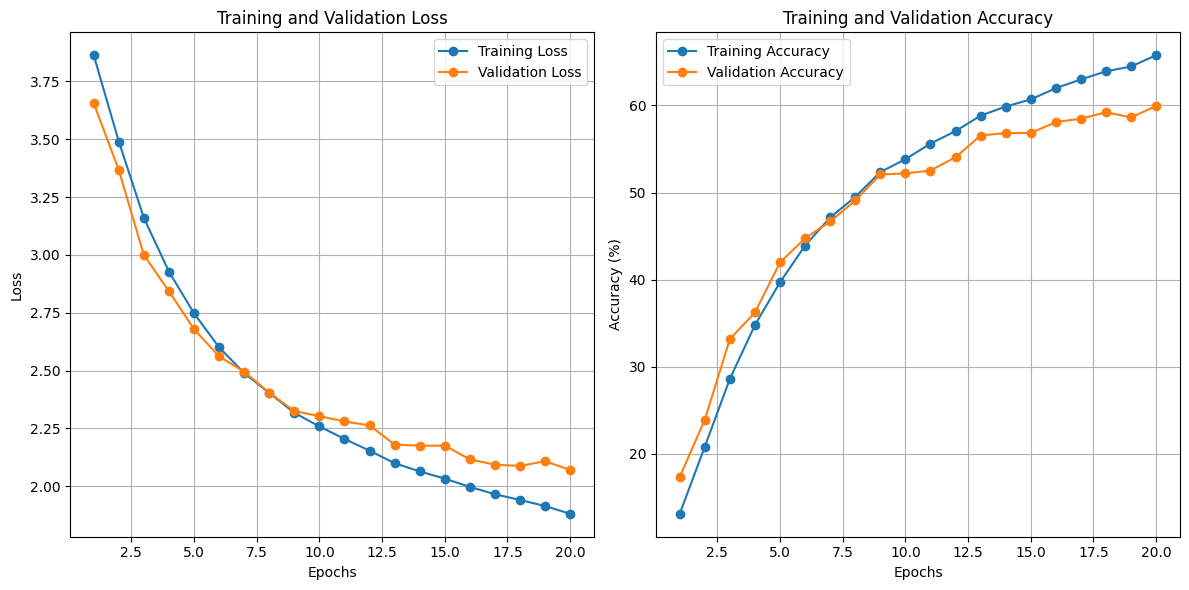

In [8]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), validation_loss_list, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), validation_accuracy_list, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

In [9]:
model.load_state_dict(torch.load('custom_resnet_cifar100.pth', map_location=device, weights_only=True))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (con

In [10]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

def preprocess_image(row):
    pixel_data = row[[f'pixel_{i}' for i in range(1, 3073)]].values.astype(np.float32)
    image = pixel_data.reshape(3, 32, 32)
    image_tensor = torch.tensor(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))(image_tensor)
    return image_tensor

# Predict on the test set
predictions = []
for index, row in test_df.iterrows():
    image_tensor = preprocess_image(row).to(device)
    outputs = model(image_tensor)
    _, predicted_label = torch.max(outputs, 1)
    predictions.append(predicted_label.item())


In [11]:
# Create the submission DataFrame
submission_df = pd.DataFrame({'ID': test_df['ID'], 'LABEL': predictions})

# Save the submission as CSV
submission_df.to_csv('submission.csv', index=False)